## Setup

In [1]:
using Turing
using Pkg
using Plots
using DataFrames
using Statistics
using StatsBase
Pkg.status("Turing")

Status `~/Projects/de_github/TuringTutorials/Project.toml`
  [fce5fe82] Turing v0.13.0


## Now let's construct a simple linear model and sample from it

We'll generate some date and split between a training and test sample. We will perform inference with the training sample and then do a prediction with the test xs.

In [2]:
@model function linear_reg(x, y, σ = 0.1)
           β ~ Normal(0, 1)
           for i ∈ eachindex(y)
               y[i] ~ Normal(β * x[i], σ)
           end
       end;


xs = 0:0.1:15;
ys = 2 .* xs .+ 0.1 .* randn(length(xs));

xs_train, xs_test = xs[1:130], xs[144:end]
ys_train, ys_test = ys[1:130], ys[144:end]

#Infer
m = linear_reg(xs_train, ys_train);
chain = sample(m, NUTS(100, 0.65), 500);

┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/cd/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


### What will we predict?

Since we will be using xs_train as data, we are left with:

+ Scalar β
+ Vector y. It will have the size of the training set (21 observations)

The way to get a prediction is to construct a "test model" that takes the xs_test but is passed missing values for the ys (which is what `Vector{Union{Missing, Float64}}(undef, length(ys_test))` stands for). In this way, we force the model to also sample the ys.

By default, the predict function only includes variables present in model but not present in chain. In this case, this means only the vector y will be included for prediction. However, if we set `include_all=true`, then β will also be included.

*Note*: I'm not sure why `Union{Missing, Float64}` is recommended over just `Vector{Missing]`

In [3]:
m_test = linear_reg(xs_test, Vector{Union{Missing, Float64}}(undef, length(ys_test)));
predictions = predict(m_test, chain)
all_prediction = predict(m_test, chain, include_all=true);

predictions


Object of type Chains, with data of type 400×8×1 Array{Float64,3}

Iterations        = 1:400
Thinning interval = 1
Chains            = 1
Samples per chain = 400
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se    mcse       ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ────────  ──────
        y[1]  28.5623  0.1087    0.0054  0.0022  412.5870  0.9979
        y[2]  28.7752  0.0968    0.0048  0.0039  550.1139  1.0019
        y[3]  28.9620  0.1048    0.0052  0.0025  356.0839  0.9992
        y[4]  29.1680  0.1041    0.0052  0.0036  468.9575  0.9978
        y[5]  29.3599  0.1018    0.0051  0.0100  400.0956  0.9982
        y[6]  29.5657  0.1011    0.0051  0.0056  357.7121  0.9976
        y[7]  29.7641  0.0957    0.0048  0.0044  439.0081  0.9991
        y[8]  29.9668  0.0961    0.0048  0.0027  504.7036  0.9975

Quantiles
  parameters     2.5%    25.0%    50.0%    75.

In [4]:
all_prediction

Object of type Chains, with data of type 400×9×1 Array{Float64,3}

Iterations        = 1:400
Thinning interval = 1
Chains            = 1
Samples per chain = 400
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], β

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se    mcse       ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ────────  ──────
        y[1]  28.5739  0.1059    0.0053  0.0059  391.6305  0.9996
        y[2]  28.7731  0.0950    0.0048  0.0033  402.5828  0.9992
        y[3]  28.9717  0.1025    0.0051  0.0031  410.9166  0.9985
        y[4]  29.1655  0.1052    0.0053  0.0056  429.7040  0.9987
        y[5]  29.3665  0.1012    0.0051  0.0041  504.4326  0.9982
        y[6]  29.5627  0.1062    0.0053  0.0038  413.7000  1.0006
        y[7]  29.7665  0.0943    0.0047  0.0068  464.3466  1.0071
        y[8]  29.9717  0.0997    0.0050  0.0037  382.1067  1.0001
           β   1.9977  0.0011    0.0001  0.0001  174.0

#### Plot credible intervals for the prediction

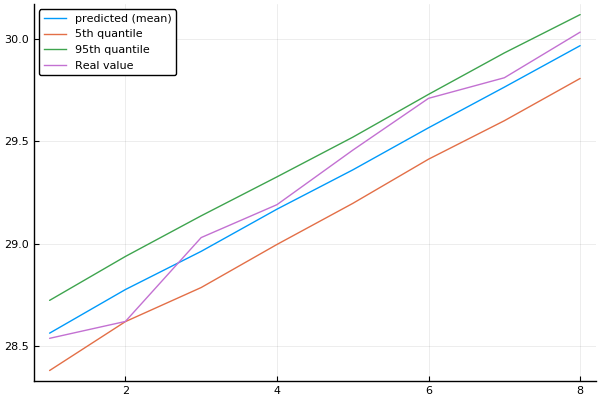

In [5]:
ordered_ys = ["y["  * string(i) * "]" for i in 1:length(ys_test)]
pred_means = [mean(predictions[y].value) for y in ordered_ys]
q_5 = [quantile!(predictions[y].value[:, 1, 1], 0.05) for y in ordered_ys]  
q_95 = [quantile!(predictions[y].value[:, 1, 1], 0.95) for y in ordered_ys] 
pyplot()

plot(pred_means, label="predicted (mean)")
plot!(q_5, label="5th quantile")
plot!(q_95, label="95th quantile")
plot!(ys_test, label="Real value")

## Prediction with a HMM model

In [6]:
using Random
Random.seed!(1234);

# Define the emission parameter.
y_train = [ 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0 ];
y_test  = [2.0, 2.0, 1.0, 1.0]

# Turing model definition.
@model BayesHmm(y, K) = begin
    N = length(y)
    s = tzeros(Int, N)
    m = Vector(undef, K)
    T = Vector{Vector}(undef, K)
    
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Normal(i, 0.5)
    end

    # Observe each point of the input.
    s[1] ~ Categorical(K)
    y[1] ~ Normal(m[s[1]], 0.1)

    for i = 2:N
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Normal(m[s[i]], 0.1)
    end
end;


g = Gibbs(HMC(0.001, 7, :m, :T), PG(20, :s))
c = sample(BayesHmm(y_train, 3), g, 100);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Now suppose we wish to predict `ys`. We set the `ys` as missing and predict

In [7]:
m_test_no_y = BayesHmm(Vector{Union{Missing, Float64}}(undef, length(y_test)), 3)
predictions = predict(m_test_no_y, c);

Besides predicting the test `ys`, we could pass the `y_test` values we have and use the model to predict the hidden states and parameters:

+ `T` transition matrix
+ `m` vector
+ `s` vector

In [8]:
m_test = BayesHmm(y_test, 3)
#This doesn't work, because there are no parameters left
#predictions = predict(m_test, c);

#But this does work:
all_predictions = predict(m_test, c, include_all=true)

Object of type Chains, with data of type 100×16×1 Array{Float64,3}

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
parameters        = T[1][1], T[1][2], T[1][3], T[2][1], T[2][2], T[2][3], T[3][1], T[3][2], T[3][3], m[1], m[2], m[3], s[1], s[2], s[3], s[4]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se     mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ───────  ────────  ──────
     T[1][1]  0.3838  0.3624    0.0362  missing  104.4004  0.9927
     T[1][2]  0.2769  0.3221    0.0322  missing  121.1886  0.9922
     T[1][3]  0.3393  0.3351    0.0335  missing  141.3466  0.9901
     T[2][1]  0.3220  0.3401    0.0340  missing  108.4740  0.9921
     T[2][2]  0.3000  0.3161    0.0316  missing  168.1943  0.9953
     T[2][3]  0.3780  0.3373    0.0337  missing   87.6225  0.9904
     T[3][1]  0.3288  0.3288    0.0329  missing  116.1646  0.9900
     T[3][2]  0.2729  0.3241    0.0324  missing